<a href="https://colab.research.google.com/github/zahBayat/ModelOnCMB/blob/main/data_provider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd /gdrive/My\ Drive/

/gdrive/My Drive


In [ ]:
!pip install git+https://github.com/vafaei-ar/ccgpack.git

  Cloning https://github.com/vafaei-ar/ccgpack.git to /tmp/pip-req-build-0eyf00r8
  Running command git clone -q https://github.com/vafaei-ar/ccgpack.git /tmp/pip-req-build-0eyf00r8
  Created wheel for ccgpack: filename=ccgpack-0.1.0-cp37-cp37m-linux_x86_64.whl size=910061 sha256=1822df3e732fa6ad3b17b12d274aba2d5fe5feaa43fab1541cdc3a2e4acaa402
  Stored in directory: /tmp/pip-ephem-wheel-cache-whm6kv7g/wheels/12/6f/95/7ae57565d174cea0e92a0da0a36f289e045f46ef2173da656b
Successfully built ccgpack


In [ ]:
import os
import numpy as np
import pylab as plt
from glob import glob
from random import choice,shuffle

In [ ]:
g_files = sorted(glob('./data/Healpix_p/*.npy'))

if len(g_files)==0:
    print('Somthing is wrong with initiation.')
    #exit()

print(len(g_files))

409


In [ ]:
c=0 

for i in range(12):
    c+= np.std(np.load('./data/Healpix_p/'+str(i)+'.npy'))
cmb_std = c/12
cmb_std

0.00010970475098777872

In [ ]:
def get_slice(data,nx,ny):
    """Slice matrix in x and y direction"""
    lx,ly = data.shape  
    if nx==0 or nx==lx:
        slx = slice(0, lx)                
    else:
        idx = np.random.randint(0, lx - nx)            
        slx = slice(idx, (idx+nx))       
    if ny==0 or ny==ly:
        sly = slice(0, ly)                
    else:
        idy = np.random.randint(0, ly - ny)            
        sly = slice(idy, (idy+ny))
    return slx, sly


class OrganizedDataProvider(object):
    def __init__(self,n_files,
                 s2n, cmb_std,
                 nx=0,ny=0,n_buffer=10,
                 reload_rate=100,filt=None ,test=0 , noisy=1):

        self.n_files = n_files
        self.test = test
        self.cmb_std = cmb_std 
        self.s2n = s2n
        self.noisy = noisy

        nmin = len(n_files)
        if n_buffer>= nmin:
            n_buffer = nmin
            self.reload_rate = 0
        else:
            self.reload_rate = reload_rate

        self.nx,self.ny = nx,ny
        self.n_buffer = n_buffer
        if filt is None:
            def filt(x):
                return x
        self.filt = filt
        self.counter = 0
        self.reload()
            
    def reload(self):
        print('Data provider is reloading...')
        self.n_set = []
    #        self.d_set = []
        nind = np.random.randint(0,len(self.n_files))


        for i in range(self.n_buffer):
            filen = self.n_files[nind]
            self.n_set.append(np.load(filen))
           

    def get_data(self): 
        self.counter += 1
        if self.reload_rate:
            if self.counter%self.reload_rate==0: 
                self.reload() 
    #        n = choice(self.n_set)
        ind = choice(np.arange(self.n_buffer))
        n = self.n_set[ind]


        return n

    def pre_process(self, n):
        
        nslice = get_slice(n,self.nx,self.ny)
        n = n[nslice]

        if self.noisy == 1:
            noise = np.random.normal(0, self.cmb_std/self.s2n ,n.shape)
            n = n +noise

        n = self.filt(n)

        return n

    def __call__(self, n, gmus=None): 


        X = []
        # Y = []

        for i in range(n):                
            n = self.get_data()

            sn  = self.pre_process(n)

            sn = (sn - np.mean(sn))/(np.std(sn) + 1e-30)
            sn = np.expand_dims(sn,-1)

            X.append(sn)
            #            Y.append(-np.log10(gmu+1e-30))
            # Y.append(lbl)

        X = np.array(X)
        # Y = np.array(Y)

        return X

In [ ]:
dofilt = 'n'

if dofilt[0]=='y':
    import ccgpack as ccg
    def filt(x):
        return ccg.filters(x,edd_method='sch')
else:
    filt = None

In [ ]:
odp = OrganizedDataProvider(g_files,
                              s2n = 20., 
                              cmb_std = cmb_std,
                              nx=256,ny=256,n_buffer=10,
                              reload_rate=1e5,filt=filt, noisy=1)


Data provider is reloading...


In [ ]:
x = odp(10)
x.shape

(10, 256, 256, 1)

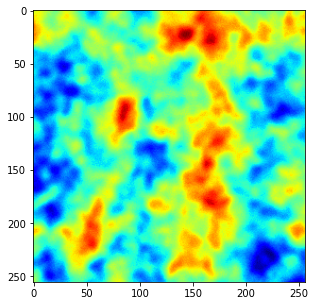

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(odp(1)[0,:,:,0] , cmap='jet')

In [ ]:
g_test = sorted(glob('./data/test/healpix_p/*.npy'))

if len(g_test)==0:
    print('Somthing is wrong with initiation.')
#     exit()
print(len(g_test))

60 12


In [ ]:
odp_test = OrganizedDataProvider(g_test,
                                    s2n = 20., 
                                    cmb_std = cmb_std,
                                    nx=256,ny=256,n_buffer=10,
                                    reload_rate=1e5,filt=filt, noisy=1)

Data provider is reloading...
